<a href="https://colab.research.google.com/github/HuyenNguyenHelen/INFO-5505---Machine-learning/blob/main/HuyenNguyen_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: K-means clustering
Dataset: [Amyotrophic Lateral Sclerosis (ALS)](https://)

Goals: Using k-means clustering algorithm to address the question:

 **What patient phenotypes can be automatically and reliably identified and used to predict the change of the ALSFRS slope over time?**


In [ ]:
# Import primary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Loading the dataset and explore the data

In [ ]:
# Load the dataset
data = pd.read_csv('/content/ALS_TrainingData_2223.csv')
data.head() 

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,bp_systolic_max,bp_systolic_median,bp_systolic_min,bp_systolic_range,Calcium_max,Calcium_median,Calcium_min,Calcium_range,Chloride_max,...,Hemoglobin_median,Hemoglobin_min,Hemoglobin_range,leg_max,leg_median,leg_min,leg_range,mouth_max,mouth_median,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
0,1,65,57.0,40.5,38.0,0.066202,-0.965608,30,28.0,22,0.021164,24.0,22.0,18.0,0.020906,31,27.5,23.0,0.027875,30.0,28.0,25.0,0.017422,8.0322,7.11945,6.5718,0.005089,90,83.0,69,0.055556,160,139.0,129,0.082011,2.49500,2.220550,2.22055,0.000956,109.0,...,146.0,143.0,0.045296,8,6.5,4,0.010582,5,3.5,0,0.013228,-1023,1,172,169.0,152.0,4.5,4.25,4.0,0.001742,79,68.0,61,0.047619,4,3.0,3,0.002646,148.0,145.5,143.0,0.017422,533,8,7.0,7,0.002646,6.0,6.0,6.0
1,2,48,45.0,41.0,39.0,0.010453,-0.921717,37,33.0,21,0.028725,25.0,13.0,8.0,0.029617,31,17.0,14.0,0.029617,32.0,28.0,25.0,0.012195,8.3973,4.74630,4.0161,0.007633,80,78.0,64,0.028725,140,132.5,104,0.064632,2.32035,2.170650,2.02095,0.000522,108.0,...,132.0,128.0,0.017422,8,7.5,3,0.008977,9,8.0,4,0.008977,-341,1,286,264.0,230.0,5.0,4.30,3.9,0.001916,90,76.0,64,0.046679,4,4.0,3,0.001795,142.0,138.0,136.0,0.010453,649,8,7.0,5,0.005386,7.0,5.0,5.0
2,3,38,50.0,47.0,45.0,0.008929,-0.914787,24,14.0,10,0.025000,25.0,20.0,14.0,0.019643,24,19.0,18.0,0.010714,35.0,29.0,24.0,0.019643,5.4765,4.38120,3.6510,0.003260,86,76.0,58,0.050000,120,110.0,90,0.053571,2.47005,2.295400,2.19560,0.000490,108.0,...,154.0,151.0,0.017857,4,3.0,2,0.003571,10,7.0,4,0.010714,-1181,1,233,213.0,167.0,4.1,4.00,3.9,0.000357,82,73.0,60,0.039286,4,4.0,4,0.000000,145.0,143.0,140.0,0.008929,1234,5,0.0,0,0.008929,6.0,5.0,5.0
3,4,63,47.0,44.0,41.0,0.012111,-0.598361,30,29.0,24,0.014963,62.0,60.0,41.0,0.052369,46,40.0,33.0,0.032419,23.0,20.0,20.0,0.007481,8.0322,8.03220,6.5718,0.003642,90,80.0,70,0.049875,150,130.0,120,0.074813,2.47005,2.345300,2.23000,0.000474,109.0,...,145.0,144.0,0.024938,4,3.5,2,0.004988,12,12.0,12,0.000000,-365,2,275,233.0,204.0,4.3,4.20,4.0,0.000748,84,72.0,68,0.039900,3,3.0,3,0.000000,143.0,139.0,138.0,0.012469,2492,5,5.0,3,0.004988,7.0,6.0,5.0
4,5,63,47.0,45.5,42.0,0.008292,-0.444039,32,27.5,20,0.020374,38.0,26.5,22.0,0.026534,35,26.5,20.0,0.024876,32.0,28.0,23.0,0.014925,5.1114,4.19865,3.6510,0.002422,100,80.0,68,0.053068,160,130.0,104,0.092869,2.42015,2.257975,2.17065,0.000414,107.0,...,146.5,138.0,0.023217,2,2.0,0,0.003396,12,12.0,12,0.000000,-1768,2,313,283.5,268.0,4.6,3.75,3.5,0.001824,101,96.0,74,0.044776,4,4.0,3,0.001698,143.0,140.0,138.0,0.008292,2956,6,4.0,1,0.008489,6.0,5.0,5.0


In [ ]:
# Print feature names
print('column names: \n', [name for name in data.columns])

column names: 
 ['ID', 'Age_mean', 'Albumin_max', 'Albumin_median', 'Albumin_min', 'Albumin_range', 'ALSFRS_slope', 'ALSFRS_Total_max', 'ALSFRS_Total_median', 'ALSFRS_Total_min', 'ALSFRS_Total_range', 'ALT.SGPT._max', 'ALT.SGPT._median', 'ALT.SGPT._min', 'ALT.SGPT._range', 'AST.SGOT._max', 'AST.SGOT._median', 'AST.SGOT._min', 'AST.SGOT._range', 'Bicarbonate_max', 'Bicarbonate_median', 'Bicarbonate_min', 'Bicarbonate_range', 'Blood.Urea.Nitrogen..BUN._max', 'Blood.Urea.Nitrogen..BUN._median', 'Blood.Urea.Nitrogen..BUN._min', 'Blood.Urea.Nitrogen..BUN._range', 'bp_diastolic_max', 'bp_diastolic_median', 'bp_diastolic_min', 'bp_diastolic_range', 'bp_systolic_max', 'bp_systolic_median', 'bp_systolic_min', 'bp_systolic_range', 'Calcium_max', 'Calcium_median', 'Calcium_min', 'Calcium_range', 'Chloride_max', 'Chloride_median', 'Chloride_min', 'Chloride_range', 'Creatinine_max', 'Creatinine_median', 'Creatinine_min', 'Creatinine_range', 'Gender_mean', 'Glucose_max', 'Glucose_median', 'Glucose_m

In [ ]:
# Expore missing values
data.isnull().sum()

ID                 0
Age_mean           0
Albumin_max        0
Albumin_median     0
Albumin_min        0
                  ..
trunk_min          0
trunk_range        0
Urine.Ph_max       0
Urine.Ph_median    0
Urine.Ph_min       0
Length: 101, dtype: int64

There is no missing data, so we don't have to clean the data.

In [ ]:
# Explore the dataset with some summary statistics
data.describe()

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,bp_systolic_max,bp_systolic_median,bp_systolic_min,bp_systolic_range,Calcium_max,Calcium_median,Calcium_min,Calcium_range,Chloride_max,...,Hemoglobin_median,Hemoglobin_min,Hemoglobin_range,leg_max,leg_median,leg_min,leg_range,mouth_max,mouth_median,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
count,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,...,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000
mean,1214.874944,54.550157,47.011134,43.952542,40.766347,0.013779,-0.728274,31.692308,27.104926,19.877193,0.026035,54.436257,32.993252,23.014800,0.071137,43.127755,29.076923,21.542465,0.049191,30.897301,26.963765,23.164327,0.016868,7.353054,5.558011,4.160875,0.007133,92.030589,81.113360,69.890688,0.047658,147.135403,129.579172,113.429600,0.071178,2.474835,2.345584,2.222855,0.000541,107.152182,...,144.289024,135.461130,0.038242,5.309942,4.049708,2.493477,0.006163,10.743140,9.703329,7.778228,0.006595,-682.995502,1.800720,285.301844,238.781601,208.382005,4.628367,4.189269,3.857323,0.001744,90.642375,76.973234,65.373819,0.053587,3.910031,3.592668,2.791273,0.002513,143.428880,140.145254,136.755061,0.015000,498880.290148,6.203779,4.893387,2.955915,0.007136,6.820450,5.710639,5.183221
std,696.678300,11.396546,3.233980,2.654804,3.193087,0.009567,0.622329,5.314228,6.633643,8.583509,0.016156,44.829577,15.601925,11.231221,0.110889,35.288701,9.593911,7.395303,0.084100,3.164472,2.198824,2.408519,0.011280,2.319538,1.335236,1.354256,0.005070,8.758227,7.245578,8.443662,0.027282,15.754048,12.160938,11.195037,0.033110,0.180246,0.088418,0.172787,0.000481,2.616967,...,11.602846,14.890612,0.035134,2.244651,2.280781,2.124570,0.004372,1.897501,2.771850,3.740073,0.006128,411.800405,0.419334,70.175312,52.626504,49.321238,1.325412,0.243075,0.263050,0.002898,11.104866,8.437749,7.763446,0.027403,0.298516,0.612385,1.055428,0.002477,2.333157,1.789886,2.715247,0.009283,289923.528450,1.747660,2.146076,2.358095,0.004503,0.932141,0.625039,0.437222
min,1.000000,18.000000,37.000000,34.500000,24.000000,0.000000,-4.345238,11.000000,2.500000,0.000000,0.000000,10.000000,8.000000,1.600000,0.002747,11.000000,9.000000,1.000000,0.000000,20.000000,19.500000,2.500000,0.000000,2.920800,2.190600,0.584160,0.000000,70.000000,56.000000,20.

## Data preprocessing

### Data Standardization
Looking at min, max, and standard deriviation, we see that data have different value scales/ranges. K-means clustering algorithm implements Eclidean distance to calculate distance among data points that greater values have stronger influence. For example, the weight is normally more influencial than the height. Therefore, standardization, known as feature scaling, is an important step in k-means clustering. We will be standardizing our dataset below: 

In [ ]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data= scaler.fit_transform(data)

# Turn scaled data into dataframe for convenience
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df.columns = [c for c in data.columns]

scaled_data_df.head()

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,bp_systolic_max,bp_systolic_median,bp_systolic_min,bp_systolic_range,Calcium_max,Calcium_median,Calcium_min,Calcium_range,Chloride_max,...,Hemoglobin_median,Hemoglobin_min,Hemoglobin_range,leg_max,leg_median,leg_min,leg_range,mouth_max,mouth_median,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
0,-1.742767,0.917137,3.089417,-1.300781,-0.866550,5.480929,-0.381450,-0.318520,0.134960,0.247368,-0.301588,-0.679085,-0.704767,-0.446606,-0.453087,-0.343750,-0.164404,0.197134,-0.253516,-0.283619,0.471374,0.762330,0.049077,0.292860,1.169674,1.780659,-0.403233,-0.231902,0.260444,-0.105510,0.289532,0.816774,0.774854,1.391144,0.327228,0.111898,-1.414439,-0.013342,0.863965,0.706250,...,0.147495,0.506397,0.200822,1.198700,1.074563,0.709255,1.011076,-3.027367,-2.238477,-2.080167,1.082677,-0.825839,-1.909933,-1.614917,-1.326277,-1.143416,-0.096872,0.249901,0.542515,-0.000570,-1.048639,-1.063702,-0.563513,-0.217842,0.301454,-0.968019,0.197810,0.053311,1.959640,2.992342,2.300470,0.260968,-1.719279,1.028018,0.981832,1.715365,-0.997420,-0.880376,0.463054,1.868532
1,-1.741331,-0.574879,-0.622016,-1.112401,-0.553303,-0.347725,-0.310907,0.998995,0.888863,0.130839,0.166537,-0.656774,-1.281749,-1.337181,-0.374515,-0.343750,-1.259094,-1.020129,-0.232796,0.348541,0.471374,0.762330,-0.414378,0.450297,-0.608052,-0.106928,0.098656,-1.373942,-0.429788,-0.697803,-0.694129,-0.453027,0.240235,-0.842491,-0.197758,-0.857276,-1.978932,-1.168779,-0.039684,0.324043,...,-1.059377,-0.501175,-0.592730,1.198700,1.513108,0.238466,0.643794,-0.918857,-0.614648,-1.010429,0.388826,0.830675,-1.909933,0.009951,0.479304,0.438409,0.280454,0.455645,0.162274,0.059556,-0.057859,-0.115369,-0.177000,-0.252168,0.301454,0.665307,0.197810,-0.289979,-0.612561,-1.198812,-0.278144,-0.489913,-1.718879,1.028018,0.981832,0.867032,-0.388669,0.192665,-1.137208,-0.419151
2,-1.739896,-1.452535,0.924415,1.148162,1.326179,-0.507103,-0.299769,-1.447819,-1.975969,-1.150976,-0.064100,-0.656774,-0.832985,-0.802836,-0.464480,-0.542158,-1.050582,-0.479123,-0.457607,1.296780,0.926265,0.347043,0.246046,-0.809203,-0.881549,-0.376583,-0.763966,-0.688718,-0.705880,-1.408555,0.085852,-1.722828,-1.610367,-2.093327,-0.531883,-0.026555,-0.567701,-0.157771,-0.105200,0.324043,...,0.837136,1.043769,-0.580331,-0.583715,-0.460344,-0.232324,-0.592848,-0.391730,-0.975499,-1.010429,0.672452,-1.209607,-1.909933,-0.745470,-0.490008,-0.839219,-0.398733,-0.778819,0.162274,-0.478576,-0.778426,-0.470994,-0.692351,-0.522019,0.301454,0.665307,1.145505,-1.014914,0.673540,1.595291,1.195350,-0.654169,-1.716861,-0.688950,-2.280669,-1.253800,0.398249,-0.880376,-1.137208,-0.419151
3,-1.738460,0.741606,-0.003443,0.017880,0.073191,-0.174361,0.208801,-0.318520,0.285741,0.480425,-0.685524,0.168760,1.731378,1.601718,-0.169287,0.081411,1.138799,1.549648,-0.199469,-2.496176,-3.167753,-1.314102,-0.832374,0.292860,1.853414,1.780659,-0.688597,-0.231902,-0.153695,0.012949,0.081281,0.181873,0.034613,0.587035,0.109797,-0.026555,-0.003208,0.041362,-0.138785,0.706250,...,0.061290,0.573569,-0.378758,-0.583715,-0.241072,-0.232324,-0.268864,0.662526,0.828

In [ ]:
# Explore some basic statistics of the scaled data
scaled_data_df.describe()

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,bp_systolic_max,bp_systolic_median,bp_systolic_min,bp_systolic_range,Calcium_max,Calcium_median,Calcium_min,Calcium_range,Chloride_max,...,Hemoglobin_median,Hemoglobin_min,Hemoglobin_range,leg_max,leg_median,leg_min,leg_range,mouth_max,mouth_median,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
count,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,...,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03,2.223000e+03
mean,-2.071617e-16,-1.760975e-16,-4.248364e-16,-5.649502e-16,-3.092943e-16,9.598959e-17,-3.236278e-17,-2.115567e-16,-9.159465e-17,3.419067e-16,2.477151e-17,-9.269338e-17,1.717774e-16,2.154022e-16,5.534884e-17,-3.961693e-17,1.598786e-17,5.951155e-16,-1.149927e-17,3.277948e-16,-5.948720e-16,1.489537e-16,-1.164660e-16,-3.104741e-16,4.426409e-16,5.633520e-17,-2.487139e-17,3.278979e-16,3.952079e-16,3.481402e-16,8.735265e-17,5.473954e-16,-9.572271e-16,-1.263547e-16,-1.644109e-16,-4.138240e-16,-1.572292e-15,1.309893e-15,-7.571292e-17,4.494356e-15,...,-5.823302e-17,7.225689e-16,7.938525e-17,1.066773e-16,1.420366e-16,8.929729e-17,3.718223e-17,6.652348e-17,-3.025520e-16,-1.391400e-16,5.933176e-17,-1.009838e-16,-1.948759e-16,2.325325e-16,1.485292e-16,1.086251e-16,2.620985e-16,2.094691e-15,2.341507e-15,9.339258e-17,-1.633122e-16,-6.867601e-16,-4.718698e-16,-1.221095e-16,-3.817609e-16,-6.910052e-16,2.274384e-16,-1.699046e-16,-5.029765e-15,-1.017575e-14,-4.276375e-15,-1.178644e-17,2.717874e-16,-2.351296e-16,2.389252e-16,1.001848e-16,1.112720e-16,1.143285e-15,9.369224e-17,-2.262398e-17
std,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,...,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.000225e+00,1.0002

It seems all variable values have the same magnitude now with a mean = 0

### Selecting variables for inputting into the k-means clustering model
The dataset has 101 columns. Inputting all of them into the model would make it very complex, and the cluster interpretation would be problematic. 

Looking at the dataset, we will drop insignificant variables such as ID. Using Principle Component Analysis (PCA) would be a good method to reduce dimensions of this dataset, but here we still can manually select variables. Among each three columns of min, max, and median, we can select the 'median' columns to represent for the 'min' and 'max' columns. 



In [ ]:
# Drop the ID, max and min columns
selected_variables = [c for c in data.columns if c.lower()[-3:] != 'min' and c.lower()[-3:] != 'max' and c.lower() != 'id']
print('selected variables: ', selected_variables)

selected variables:  ['Age_mean', 'Albumin_median', 'Albumin_range', 'ALSFRS_slope', 'ALSFRS_Total_median', 'ALSFRS_Total_range', 'ALT.SGPT._median', 'ALT.SGPT._range', 'AST.SGOT._median', 'AST.SGOT._range', 'Bicarbonate_median', 'Bicarbonate_range', 'Blood.Urea.Nitrogen..BUN._median', 'Blood.Urea.Nitrogen..BUN._range', 'bp_diastolic_median', 'bp_diastolic_range', 'bp_systolic_median', 'bp_systolic_range', 'Calcium_median', 'Calcium_range', 'Chloride_median', 'Chloride_range', 'Creatinine_median', 'Creatinine_range', 'Gender_mean', 'Glucose_median', 'Glucose_range', 'hands_median', 'hands_range', 'Hematocrit_median', 'Hematocrit_range', 'Hemoglobin_median', 'Hemoglobin_range', 'leg_median', 'leg_range', 'mouth_median', 'mouth_range', 'onset_delta_mean', 'onset_site_mean', 'Platelets_median', 'Potassium_median', 'Potassium_range', 'pulse_median', 'pulse_range', 'respiratory_median', 'respiratory_range', 'Sodium_median', 'Sodium_range', 'SubjectID', 'trunk_median', 'trunk_range', 'Urine.

## Developping the K-mean clustering models


### Baseline model
For this basedlined model, we will input previous selected variables, and a k = 3 that is often selected for k-means clustering.

- Input: Selected variables: ['Age_mean', 'Albumin_median', 'Albumin_range', 'ALSFRS_slope', 'ALSFRS_Total_median', 'ALSFRS_Total_range', 'ALT.SGPT._median', 'ALT.SGPT._range', 'AST.SGOT._median', 'AST.SGOT._range', 'Bicarbonate_median', 'Bicarbonate_range', 'Blood.Urea.Nitrogen..BUN._median', 'Blood.Urea.Nitrogen..BUN._range', 'bp_diastolic_median', 'bp_diastolic_range', 'bp_systolic_median', 'bp_systolic_range', 'Calcium_median', 'Calcium_range', 'Chloride_median', 'Chloride_range', 'Creatinine_median', 'Creatinine_range', 'Gender_mean', 'Glucose_median', 'Glucose_range', 'hands_median', 'hands_range', 'Hematocrit_median', 'Hematocrit_range', 'Hemoglobin_median', 'Hemoglobin_range', 'leg_median', 'leg_range', 'mouth_median', 'mouth_range', 'onset_delta_mean', 'onset_site_mean', 'Platelets_median', 'Potassium_median', 'Potassium_range', 'pulse_median', 'pulse_range', 'respiratory_median', 'respiratory_range', 'Sodium_median', 'Sodium_range', 'SubjectID', 'trunk_median', 'trunk_range', 'Urine.Ph_median']

- k=3


In [ ]:
# Import k-mean clustering package from sklearn
from sklearn.cluster import KMeans

# Setting parameters for the k-means model by a dictionary unpacking operator 
kmeans_para= {'init':'k-means++', # set k-means++ initial algorithm that ensures a smarter initialization of the centroids
              'n_init': 10,
              'max_iter':  300, # the number of maximum iterations for each initialization
              'random_state': 42 # make sure we got the same set of pseudo random number each time we run.
              } 

# Build a k-means clustering model
kmeans_base = KMeans (n_clusters = 3, **kmeans_para)
 
# Fit the model into scaled data that we selected variables for input
kmeans_base.fit(scaled_data_df[selected_variables])

# Print SSE of the model:
print('SSE of the based model: ', kmeans_base.inertia_)

SSE of the based model:  101848.99173938962


SSE (sum squared error) is the sum of the squared differences between each observation and mean of the cluster that it was assigned to belong. Our SSE of the based model is too high. Increasing the number of clusters will reduce this SSE. However, it may not improve SSE much, because we do not expect to have too many clusters. That would be hard to interprete the formed clusters.Therefore, we can think about reducing some more variables first.

Our aim in this assignment is to address the question: **"What patient phenotypes can be automatically and reliably identified and used to predict the change of the ALSFRS slope over time?"** So we can investigate how other variable correlated with the ALSFRS slope.

In [ ]:
# Caculate correlation score of other variables toward the ALSFRS_slope
cor = pd.DataFrame(data.corrwith(data['ALSFRS_slope']), columns = [ 'score'])
print('Variables negatively correlated with ALSFRS_slope: ' )
print(cor[cor['score'] <= -0.2], '\n')
print('Variables positively correlated with ALSFRS_slope: ' )
print(cor[cor['score'] >= 0.2])

Variables negatively correlated with ALSFRS_slope: 
                       score
Albumin_range      -0.226123
ALSFRS_Total_range -0.819305
hands_range        -0.632350
Hemoglobin_range   -0.209774
leg_range          -0.584507
mouth_range        -0.553194
onset_delta_mean   -0.324307
pulse_range        -0.236961
respiratory_range  -0.432878
trunk_range        -0.686407 

Variables positively correlated with ALSFRS_slope: 
                        score
ALSFRS_slope         1.000000
ALSFRS_Total_median  0.247250
ALSFRS_Total_min     0.601810
hands_min            0.424107
leg_min              0.348967
mouth_median         0.244704
mouth_min            0.435538
respiratory_min      0.380749
trunk_min            0.488530


It makes sense to input these highly correlated variables into the model. 

### Refining model
Based on the above correlation scores of others variables toward the  ALSFRS_slope, we input into the model below variables:

- Input: ['ALSFRS_slope', 'Albumin_range', 'ALSFRS_Total_range', 'hands_range', 'Hemoglobin_range', 'leg_range', 'mouth_range', 'onset_delta_mean', 'pulse_range', 'respiratory_range', 'trunk_range', 'ALSFRS_Total_median', 'ALSFRS_Total_min', 'hands_min', 'leg_min','mouth_median', 'respiratory_min', 'trunk_min', 'Age_mean']

- k: To select an optimal k, we have to experiment a set of models with different k


#### Selecting an appropriate number of clusters
With k-means clustering algorithm, selecting a proper numer of clusters k is problematic. The selected k should be able to minimize the variability, distances among observations within clusters (SSE), but maximize the dissimility, distances among clusters. 

Two common methods to select a proper k are the elbow method, and the silhouette coefficient. Since none of them are better, but they should be used together to strengthen our decision. So here, we are going to find an appropriate k with both methods.

##### **Selecting k by applying the elbow method**

In [ ]:
# Select input variables based on the above correlation assumption
new_selected_var = ['ALSFRS_slope','Albumin_range', 'ALSFRS_Total_range', 'hands_range', 'Hemoglobin_range', 'leg_range', 'mouth_range', 'onset_delta_mean', 'pulse_range', 'respiratory_range', 'trunk_range', 'ALSFRS_Total_median', 'ALSFRS_Total_min', 'hands_min', 'leg_min','mouth_median', 'respiratory_min', 'trunk_min', 'Age_mean']

# Build and run a set of k-mean models over a range of k
sse=[]
for k in range (1,11):
  # build k-means models
  kmeans_k= KMeans (n_clusters = k, **kmeans_para)
  # fit the model into the data
  kmeans_k.fit(scaled_data_df[new_selected_var])
  # append the lowest sse value for each k assignment
  sse.append (kmeans_k.inertia_)

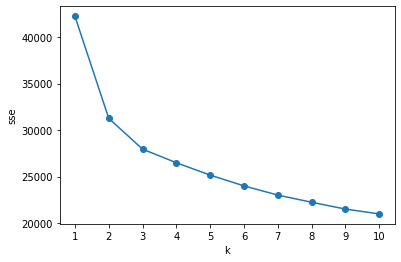

In [ ]:
# Visualize the elbow of sse
x=[i for i in range (1,11)]
y=sse
plt.plot(x, y, marker='o')
plt.xticks(x)
plt.xlabel('k')
plt.ylabel('sse')
plt.show()

We can see SSE of the refined models is very much lower than the based model's. 
 
Looking at the elbow plot, we see that k = 2 results a greater difference in SSE from its neighbors. But we also can consider k = 2, k=3, or k=4, since two clusters may cause clusters too general.

Let see their Silhouette coefficients.

##### **Selecting k by applying Silhouette coefficient **
This method measures the cohesion within clusters and disimilarity between cluster. This score ranges from -1 to 1. The greater the score is, the better the model performs. 

In [ ]:
# Build and run a series of k-mean models over a range of k to get the Silhoutte coefficient

# import the library
from sklearn.metrics import silhouette_score

sil_cofs=[]
for k in range (2,11):
  # build k-means models
  kmeans_k = KMeans (n_clusters = k, **kmeans_para)
  # fit the model into the data
  kmeans_k.fit(scaled_data_df[new_selected_var])
  # get Silhouette coefficient score
  sil_cof_score = silhouette_score(scaled_data_df[new_selected_var],kmeans_k.labels_ )
  # append the silhouette score for each k assignment
  sil_cofs.append (sil_cof_score)

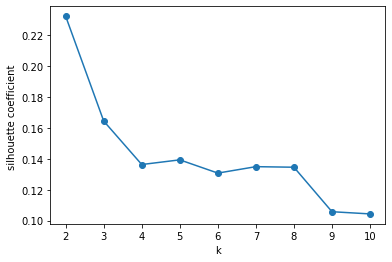

In [ ]:
# Visualize the silhoutte efficient for each k
x=[i for i in range (2,11)]
y=sil_cofs
plt.plot(x, y, marker='o')
plt.xticks(x)
plt.xlabel('k')
plt.ylabel('silhouette coefficient ')
plt.show()

The highest silhouette scores are for k=2, k=3, and k=5 respectively. However, two clusers are often too few because its clusters would be too general. It seems k=3 is the optimum using these two validation methods.

## The Final Model 
From the above experiment, we select k = 3 for its good SSE, Silhouette score.


*   Inputs: ['ALSFRS_slope', 'Albumin_range', 'ALSFRS_Total_range', 'hands_range', 'Hemoglobin_range', 'leg_range', 'mouth_range', 'onset_delta_mean', 'pulse_range', 'respiratory_range', 'trunk_range', 'ALSFRS_Total_median', 'ALSFRS_Total_min', 'hands_min', 'leg_min','mouth_median', 'respiratory_min', 'trunk_min', 'Age_mean']
*   k = 3



In [ ]:
# Build a k-means clustering model with k =3
kmeans_k3 = KMeans (n_clusters = 3, **kmeans_para)

# fit the model into the scaled selected feature values
kmeans_k3.fit(scaled_data_df[new_selected_var])

# print the SSE of the model
print ('SSE of the final model: {:.2f}'.format(kmeans_k3.inertia_))

# apply the model to cluster the dataset
pred = kmeans_k3.predict(scaled_data_df[new_selected_var])

SSE of the final model: 27949.50


In [ ]:
# Observe the data sizes of the formed clusters
scaled_data_df['cluster'] = pred
scaled_data_df['cluster'].value_counts()

2    876
1    866
0    481
Name: cluster, dtype: int64

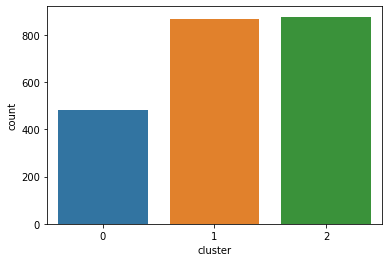

In [ ]:
# Plot the cluster sizes
sns.countplot(x='cluster', data=scaled_data_df)
plt.show()

We can see data sizes of three clusters are quite balanced. This is what we aimed to achieve.

## Cluster Interpretation
Interpretability is especially important for k-means clustering, and unsupervised machine learning in general.


In [ ]:
# Print centroids of clusters
centroids  = kmeans_k3.cluster_centers_

# Turn it into a dataframe for observation 
centroids_df = pd.DataFrame(centroids, columns = new_selected_var )
print ('\t'*5, ' The Table of Centroids')
centroids_df


					  The Table of Centroids


,ALSFRS_slope,Albumin_range,ALSFRS_Total_range,hands_range,Hemoglobin_range,leg_range,mouth_range,onset_delta_mean,pulse_range,respiratory_range,trunk_range,ALSFRS_Total_median,ALSFRS_Total_min,hands_min,leg_min,mouth_median,respiratory_min,trunk_min,Age_mean
0,-1.264333,0.539050,1.448066,1.022375,0.505793,0.957213,1.175220,0.490750,0.491638,0.999952,1.131884,-0.609363,-1.087371,-0.619033,-0.596205,-0.659378,-0.882169,-0.777497,0.184294
1,0.663971,-0.159856,-0.780969,-0.686214,-0.212486,-0.476700,-0.537923,-0.116422,-0.221799,-0.494825,-0.693139,0.801546,1.002517,0.903143,0.730457,0.319564,0.516262,0.971849,0.081438
2,0.036352,-0.137182,-0.021383,0.118040,-0.067010,-0.053182,-0.112046,-0.153636,-0.050066,-0.058675,0.064942,-0.457976,-0.394802,-0.553006,-0.394980,0.045335,-0.026957,-0.534120,-0.181284


A good k-means cluster would produce clusters which have a high dissimilarity among clusters. That means distances between clusters' centroids should be as far as possible. Comparing distances between centroids of our clusters in each variable, we see that clusters are not significantly distanced from each other in some variables such as: onset_delta_mean, Albumin_range, hands_min, Age_mean, etc. However, they keep good distance from each other in many following variables:	leg_range, mouth_range, respiratory_range, mouth_median, respiratory_min, etc. 

The ALSFRS slope is the rate of change of the ALSFRS-R scores throughout time to determine the speed of progression of the Amyotrophic Lateral Sclerosis (ALS)disease. It can be used as a prognostic indicator.

Centroids of clusters in each variable can tell us something about characteristics of the clusters that is important to us to interprete clusters.

To address the major question of the assignment regarding determining patient phenotypes for predicting the ALSFRS slope, here we can summarize some typical characteristics of patients in the 3 clusters as follows:


*   **Cluster 0**:**Slowest progressors**. This cluster consists of the patients who have the lowest ALSFRS slopes. These patients have the highest abilities of physical motions such as hands, legs, mouths, pulse, trunk, respiratory, etc. Also, their hemoglobin and almubin are significantly higher than other patient groups. Intestingly, they are oldest compared to patients in other groups. 
*   **Cluster 1**: **Fastest progressors**. It includes patients who have the highest ALSFRS slopes. These patients have least abilities of hand, leg, mouth, trunk, pulse, respiratory motions. The albumin and hemoglobin ranges in their blood are also the least. Their ages are medium among three patient groups.
*   **Cluster 2**: **Medium progressors**. This cluster consists of patients that have the medium ALSFRS slopes.Patients in this group have medium levels of body movement capacities such as leg, hand, mouth, trunk, respiratory movements. Also, their albumin and hemoglobin in their blood are at the medium level as well. Note that this group of patients has the youngest ages compared two other groups.




/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

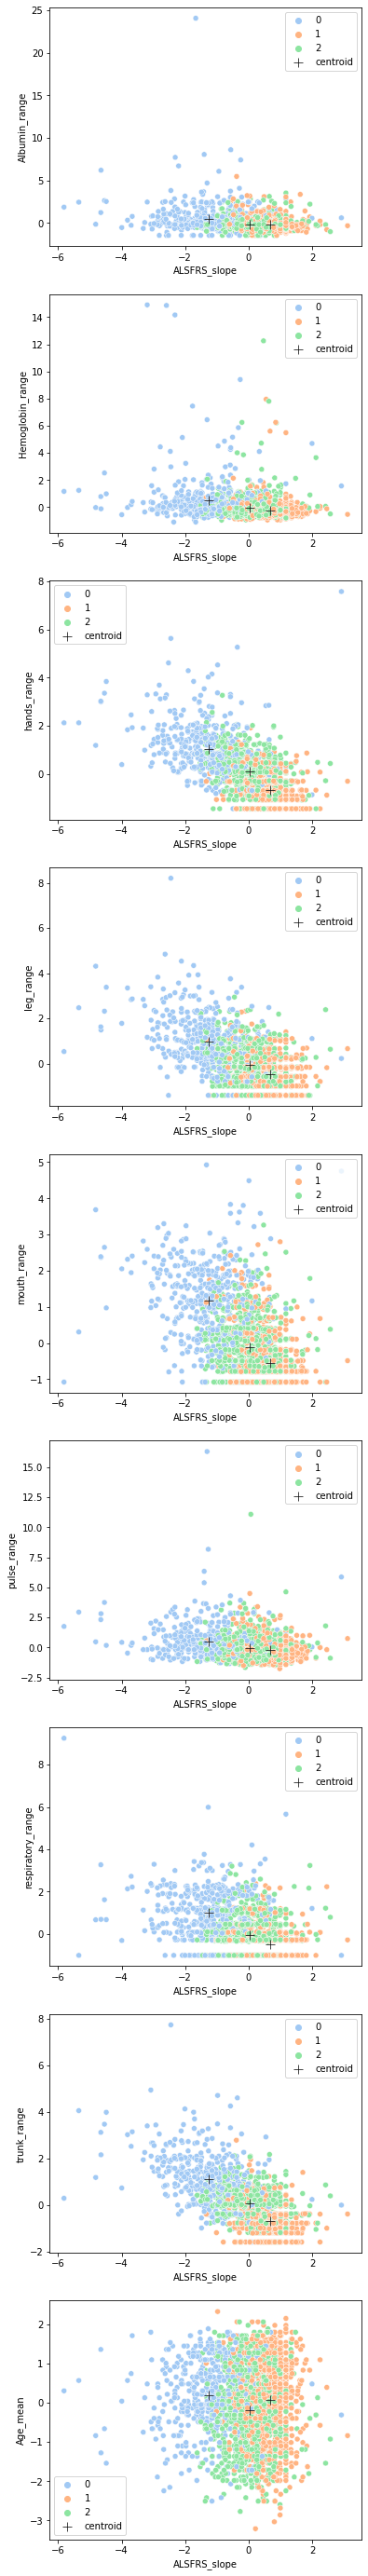

In [ ]:
# Plot centroids over the most important variables 

# Select some of the most important variables for visualizing
Y = ['Albumin_range','Hemoglobin_range', 'hands_range',  'leg_range', 'mouth_range', 'pulse_range', 'respiratory_range', 'trunk_range', 'Age_mean']

# Plot 9 sub-scatter plots
fig, ax = plt.subplots(9,1,figsize=(6,50))
for i,y in enumerate(Y):
  sns.scatterplot ( 'ALSFRS_slope',y, hue = 'cluster', palette= 'pastel', data = scaled_data_df, ax=ax[i])
  sns.scatterplot (  'ALSFRS_slope' , y,   color='.1', s = 100, marker="+",label = 'centroid', data = centroids_df, ax=ax[i])
  


## Model validation
To validate this kind of unsupervised learning algorithm, we can test our assumptions about chracteristics of three formed clusters on a test set. If they are also true for the testing set, we could conclude that the k-means clustering we built is ready for deployment.

In [ ]:
# Load the test set
test_data = pd.read_csv('/content/ALS_TestingData_78.csv')
test_data.head() 

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Basophils_max,Basophils_median,Basophils_min,Basophils_range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Bilirubin..total._max,Bilirubin..total._median,Bilirubin..total._min,Bilirubin..total._range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,BMI_max,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,...,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,Red.Blood.Cells..RBC._max,Red.Blood.Cells..RBC._median,Red.Blood.Cells..RBC._min,Red.Blood.Cells..RBC._range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min,Urine.Ph_range,White.Blood.Cell..WBC._max,White.Blood.Cell..WBC._median,White.Blood.Cell..WBC._min,White.Blood.Cell..WBC._range
0,3,65.906849,46.0,44.0,43,0.024590,-1.767329,33,5.0,2,0.028519,93,26.0,22,0.581967,72,24.0,21,0.418033,0.8,0.5,0.3,0.004098,27.0,25.0,23.0,0.032787,9.0,7.0,3.0,0.049180,7.9,7.1,5.7,0.018033,0.002969,91,76.0,69,0.180328,...,2,0.005520,-617,1,275,275.0,275,4.3,4.20,3.9,0.003279,90,77.0,61,0.237705,4700,4640,4450,2.049180,4,0.0,0,0.003680,139,138.0,137,0.016393,55888,7,0.0,0,0.006440,6.5,6.00,6.0,0.004098,8.57,7.680,6.60,0.016148
1,4,54.000000,39.0,36.0,33,0.013100,-1.351852,32,23.0,14,0.039301,47,35.5,21,0.056769,49,33.0,20,0.063319,1.2,0.7,0.3,0.001965,26.7,25.0,21.0,0.012445,19.0,9.5,5.0,0.030568,5.7,4.3,3.4,0.005022,0.002907,106,96.0,75,0.067686,...,11,0.002183,-328,4,349,270.0,215,4.6,4.20,3.8,0.001747,104,80.0,68,0.078603,5800,5100,4700,2.401747,4,4.0,3,0.002183,144,140.5,135,0.019651,61505,6,3.0,0,0.013100,6.5,5.50,5.0,0.003275,8.04,6.620,4.97,0.006703
2,5,56.394521,46.0,43.0,39,0.009736,-0.412429,15,10.0,2,0.017173,42,22.0,11,0.043115,37,22.0,14,0.031989,1.4,0.7,0.5,0.001252,27.0,24.0,20.0,0.009736,5.0,3.0,2.0,0.004172,8.2,5.4,2.9,0.007371,0.002281,85,72.5,65,0.026420,...,2,0.011889,-953,2,391,391.0,391,5.2,4.50,3.8,0.001947,123,103.5,70,0.070013,5130,4590,4190,1.307371,4,4.0,0,0.005284,141,139.0,136,0.006954,63255,0,0.0,0,0.000000,7.5,6.75,6.0,0.003456,8.90,7.160,5.01,0.005410
3,6,72.619178,50.0,42.5,41,0.092784,-0.383403,34,24.0,21,0.033592,109,39.5,20,0.917526,83,42.0,23,0.618557,0.9,0.7,0.3,0.006186,27.0,26.0,25.0,0.020619,9.0,5.0,3.0,0.061856,7.5,5.2,3.9,0.037113,0.002408,67,59.0,54,0.134021,...,2,0.015504,-490,1,383,383.0,383,4.8,4.50,4.4,0.004124,76,73.0,63,0.134021,4190,3950,3780,4.226804,4,4.0,3,0.002584,143,140.0,138,0.051546,70641,8,5.5,5,0.007752,7.5,7.00,6.0,0.024194,12.38,7.905,4.96,0.076495
4,9,65.000000,45.0,42.0,36,0.021327,0.000000,37,37.0,37,0.000000,48,16.5,13,0.082938,272,25.0,22,0.592417,1.1,0.8,0.6,0.001185,27.4,22.9,19.3,0.019194,12.0,9.5,5.0,0.016588,7.5,6.1,4.5,0.007109,0.002731,102,85.0,69,0.078199,...,12,0.000000,-329,4,357,258.0,229,5.1,4.45,4.1,0.002370,84,67.5,59,0.059242,5000,4700,4400,1.421801,4,4.0,4,0.000000,146,144.0,140,0.014218,108342,7,7.0,7,0.000000,6.0,5.50,5.0,0.002370,11.53,9.290,7.94,0.008507


In [ ]:
# Summarize the test set
test_data.describe()

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Basophils_max,Basophils_median,Basophils_min,Basophils_range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Bilirubin..total._max,Bilirubin..total._median,Bilirubin..total._min,Bilirubin..total._range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,BMI_max,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,...,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,Red.Blood.Cells..RBC._max,Red.Blood.Cells..RBC._median,Red.Blood.Cells..RBC._min,Red.Blood.Cells..RBC._range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min,Urine.Ph_range,White.Blood.Cell..WBC._max,White.Blood.Cell..WBC._median,White.Blood.Cell..WBC._min,White.Blood.Cell..WBC._range
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.00000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.00000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,51.589744,56.025571,45.256410,42.173077,38.910256,0.016753,-0.825866,29.807692,21.544872,14.705128,0.028159,59.076923,32.397436,22.358974,0.108998,48.333333,28.871795,21.089744,0.082340,1.515385,0.675000,0.319231,0.003285,27.921795,24.489103,21.187179,0.018107,12.27359,8.116795,5.198718,0.022924,7.719513,5.752032,4.204667,0.010031,0.002631,90.564103,80.141026,67.551282,0.057330,...,6.24359,0.007931,-516.589744,2.602564,311.884615,282.666667,261.153846,4.643590,4.169231,3.774359,0.002279,95.961538,78.769231,64.705128,0.076282,5070.512821,4716.474359,4360.128205,1.994449,3.846154,3.000000,1.897436,0.003678,143.192308,140.269231,137.448718,0.015560,523969.807692,5.666667,3.532051,1.871795,0.007133,7.076923,6.192308,5.564103,0.004544,9.341795,6.789103,5.286026,0.012203
std,28.468910,10.514606,3.056549,3.083341,3.977815,0.013419,0.649497,6.107389,8.995015,9.532050,0.014650,34.549708,14.820431,10.741320,0.142435,32.390742,9.358459,6.265108,0.114994,0.758857,0.210712,0.205798,0.003158,2.745700,2.202812,2.285718,0.011415,5.77224,3.241326,2.279081,0.037498,2.138344,1.524767,1.290092,0.007951,0.000405,8.730585,7.300995,7.315963,0.036190,...,4.24321,0.006029,217.304947,1.143471,78.767615,65.079605,71.993520,0.383622,0.216859,0.253513,0.001243,13.672840,9.881339,8.363664,0.047435,426.321924,372.235358,405.262441,2.020000,0.428738,1.258736,1.499695,0.003095,2.198333,1.483004,1.958315,0.009760,263604.275459,2.105445,2.511454,2.211886,0.003980,0.674570,0.572536,0.458392,0.004776,2.939529,1.683264,1.513861,0.014724
min,3.000000,24.583562,38.000000,35.000000,25.000000,0.004138,-3.041667,13.000000,2.000000,0.000000,0.000000,20.000000,14.500000,8.000000,0.015075,20.000000,16.000000,12.000000,0.013453,0.500000,0.300000,0.000000,0.000700,22.100000,20.000000,16.100000,0.005208,5.00000,3.000000,2.000000,0.003878,4

In [ ]:
# Normalizing the test data
scaled_test_data= scaler.fit_transform(test_data)

# Turn scaled data into dataframe for the convenience
scaled_test_data_df = pd.DataFrame(scaled_test_data)
scaled_test_data_df.columns = [c for c in test_data.columns]

scaled_test_data_df.describe()

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Basophils_max,Basophils_median,Basophils_min,Basophils_range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Bilirubin..total._max,Bilirubin..total._median,Bilirubin..total._min,Bilirubin..total._range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,BMI_max,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,...,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,Red.Blood.Cells..RBC._max,Red.Blood.Cells..RBC._median,Red.Blood.Cells..RBC._min,Red.Blood.Cells..RBC._range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min,Urine.Ph_range,White.Blood.Cell..WBC._max,White.Blood.Cell..WBC._median,White.Blood.Cell..WBC._min,White.Blood.Cell..WBC._range
count,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,...,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01
mean,-8.255505e-17,-9.394195e-17,3.387604e-16,1.084602e-15,3.473005e-16,-5.366078e-16,8.540177e-17,1.850372e-16,-7.686159e-17,6.262797e-17,-1.522998e-16,-1.023932e-16,-1.423363e-18,7.116814e-17,1.665335e-16,-6.067084e-17,-4.198920e-17,-2.576287e-16,-3.558407e-18,5.124106e-17,2.818258e-16,1.366428e-16,2.562053e-17,-4.118411e-16,-2.615785e-15,1.184238e-15,-2.530027e-16,2.775558e-16,6.519002e-16,-4.796733e-16,-1.779204e-17,1.508765e-16,-5.679218e-16,-4.213154e-16,1.295260e-16,-1.935773e-16,-6.063526e-16,8.070467e-16,-9.472480e-16,-8.896018e-17,...,-3.558407e-19,1.496866e-16,-2.277381e-16,-6.547469e-17,3.519265e-16,-3.188333e-16,2.875193e-16,1.361091e-15,-1.203453e-15,1.807671e-16,3.337786e-16,-3.742110e-16,-4.359049e-16,1.373545e-16,6.832142e-17,4.184687e-16,-9.750036e-16,1.152924e-16,2.163512e-16,-2.149278e-16,-5.693451e-18,1.024821e-16,-3.814612e-16,6.032212e-15,-2.968423e-15,-3.774758e-15,-2.996179e-16,1.651101e-16,-1.508765e-16,3.273735e-17,-4.270089e-17,-8.504593e-17,3.985416e-16,-3.843080e-16,4.996004e-16,-6.992270e-17,-3.857313e-16,-7.358786e-16,1.423363e-17,1.893073e-16
std,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473

The data are standardized with same means of 0. Now it is ready for predicting.

In [ ]:
# Apply the final model to cluster the test set
pred_test = kmeans_k3.predict(scaled_test_data_df[new_selected_var])

# Join the labeled column into the test set
scaled_test_data_df['cluster'] = pred_test

# Observe the sizes of three clusters
scaled_test_data_df['cluster'].value_counts()

2    37
1    24
0    17
Name: cluster, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

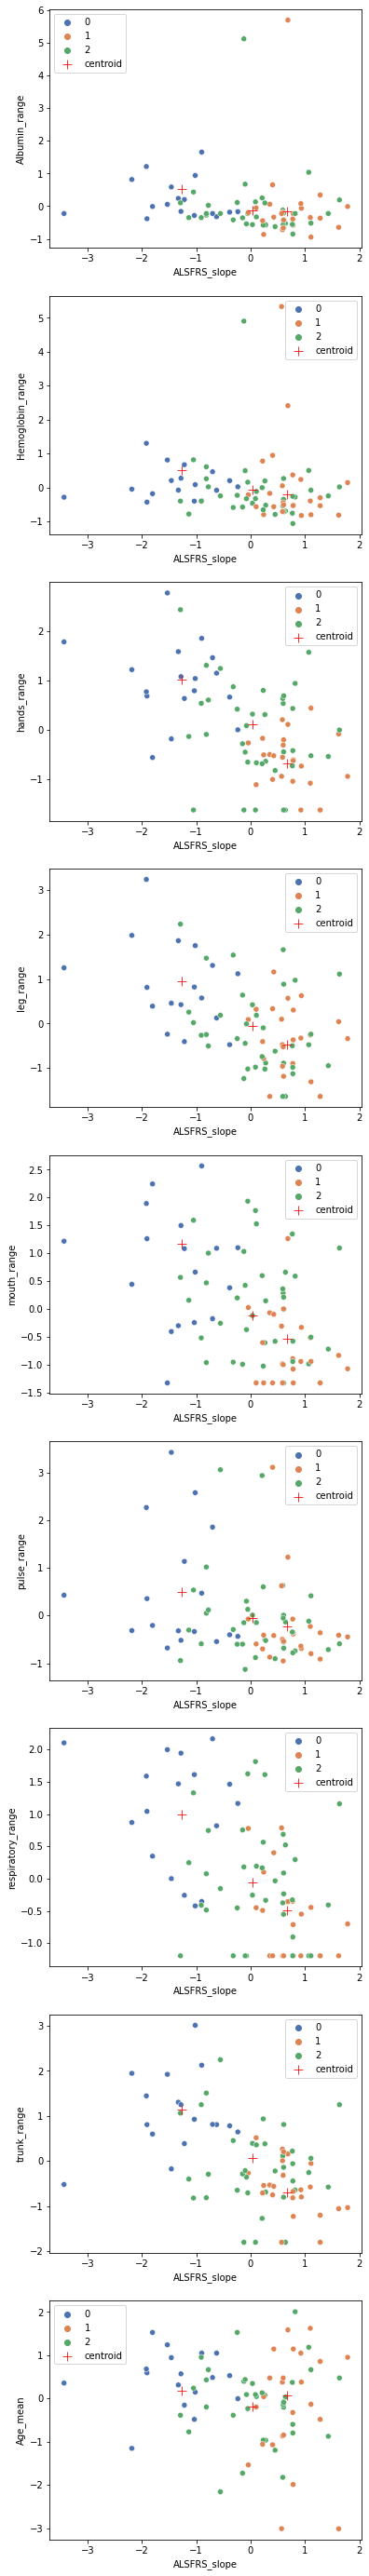

In [ ]:
# Visualize three formed clusters of the test set and models' centroids

# Plot test set in 9 most important variables 
Y = ['Albumin_range','Hemoglobin_range', 'hands_range',  'leg_range', 'mouth_range', 'pulse_range', 'respiratory_range', 'trunk_range', 'Age_mean']

# Plot 9 scatter sub-plots
fig, ax = plt.subplots(9,1,figsize=(6,50))
for i,y in enumerate(Y):
  sns.scatterplot ( 'ALSFRS_slope',y, hue = 'cluster', palette= 'deep', data = scaled_test_data_df, ax=ax[i])
  sns.scatterplot (  'ALSFRS_slope' , y,   color='red', s = 100, marker="+",label = 'centroid', data = centroids_df, ax=ax[i])

In [ ]:
# Checking the first cluster to test our assumptions
# Get a group sample of n=3 from each clusters, 
# then only print important variables that highly affects the ALSFRS slope
new_selected_var.append('cluster')
scaled_test_data_df.groupby('cluster').sample(n=3).sort_values(by=['cluster'])[new_selected_var]


,ALSFRS_slope,Albumin_range,ALSFRS_Total_range,hands_range,Hemoglobin_range,leg_range,mouth_range,onset_delta_mean,pulse_range,respiratory_range,trunk_range,ALSFRS_Total_median,ALSFRS_Total_min,hands_min,leg_min,mouth_median,respiratory_min,trunk_min,Age_mean,cluster
0,-1.458910,0.587818,0.024737,-0.183041,0.204239,0.456157,-0.402466,-0.465062,3.425035,0.000637,-0.175258,-1.851243,-1.341512,-0.829658,-0.778535,-1.326498,-1.273404,-0.851721,0.945850,0
25,-1.907236,-0.384367,1.494595,0.688367,-0.432363,0.810499,1.261981,0.836422,0.355210,1.042790,0.807813,-0.844213,-1.235924,-0.829658,-0.778535,-0.437098,-1.273404,-0.851721,0.594959,0
49,-0.700653,-0.224347,1.618957,1.465355,0.463014,1.304979,-0.172637,-0.553062,1.855720,2.167969,0.812316,-0.508536,-0.391218,-0.829658,-0.778535,0.007602,-0.602286,0.058337,0.486125,0
4,1.279778,0.343078,-1.934531,-1.626631,-0.304665,-1.636582,-1.323898,0.868843,-0.361560,-1.195987,-1.803831,1.729309,2.354077,1.741732,2.929908,1.045235,1.411069,2.333482,0.859045,1
76,0.599139,-0.668229,-1.126287,-0.307990,-0.448495,-0.521481,-0.996579,0.021258,-0.952882,-1.195987,-0.316218,1.281740,1.720547,0.456037,2.002797,1.045235,1.411069,0.968395,0.476159,1
48,0.404219,0.654385,-0.982997,-1.005665,0.946360,0.332607,-1.323898,-0.043585,3.111543,-1.195987,-0.753024,1.953094,1.614959,1.741732,0.612131,1.045235,1.411069,1.423424,-1.068495,1
11,0.606431,-0.211889,-0.217012,-0.446794,-0.350434,-0.888290,0.213641,0.317681,-0.556213,0.087628,-0.140054,-1.291782,-1.130336,-0.829658,-0.778535,-0.140632,-0.602286,-0.851721,-0.072206,2
70,0.449949,-0.626212,-0.583846,-0.825312,-0.795331,-0.620136,-0.577996,-2.053705,-0.905335,-0.033583,-0.221830,-0.396644,-0.919159,-0.829658,-0.778535,0.155835,-1.273404,-0.851721,-1.193326,2
21,0.033938,-0.563088,0.451603,0.319844,-0.465703,0.420949,-0.115990,-0.979171,0.008876,-0.254793,0.392066,0.162818,-0.602395,-0.829658,0.148575,-0.140632,0.068833,-0.396692,0.348443,2


- **Cluster 0**: **Slowest progressors**. We can see three instances of the cluster 0 contains lowest ALSFRS 
slopes. Their body motion abilities are completely the highest in leg_range, and trunk_range, but that assumption is not really true for hands_range, leg_range, and pulse_range. Their albumin_ranges are highest compared to those who are in two other groups, but this assumption is not true for their hemoglobin_range. 2 out of 3 patients are oldest.
- **Cluster 1: Fastest progressors**. 2 out of 3 instances have the highest ALSFRS slopes. Trunk_range and albumin ranges support our assumption is true regarding the lowest physical motion ability. This is not really correct for hand, leg, respiratory, and mouth ranges. Also, only 2 out of 3 have the lowest albumin and hemoglomin in blood. 
- **Cluster 2: Medium progressors.** Similarly, 2 out of three instances support our previous assumptions for hand, leg, respiratory, mouth, etc. motions. 

**Conclusion**: It is quite hard to conclude patient phenotypes for predicting the ALSFRS slope. Based on our clusters, we can make some assumptions for the three patient phenotypes. However, when testing our assumption with a test set, we found only two-third samples support our assumption. Among them, we found trunk_range and albumin could be the most competitive candidates to predict ALSFRS slope, together with some other variables regarding physical movement abilities such as hands, legs, mouths, etc, and hemoglomin in blood. The ages seem to not affect the ALSFRS slope.
